This is a walkthrough on how to use [Goombay](https://github.com/lignum-vitae/goombay) and [Biobase](https://github.com/lignum-vitae/biobase) to create a distance matrix and phylogenetic tree to show evolutionary distances between different species with the addition of a substitution matrix.

Install Goombay and Biobase using either `pip` or `uv`. For the purposes of this demonstration, we'll be using `pip`. Outside of Google Colab, the prefix "!" would be omitted while entering the following shell command in the terminal.

In [ ]:
!pip install --upgrade goombay
!pip install --upgrade biobase
!pip install --upgrade numpy
!pip install --upgrade biopython

Goombay has over 20 sequence alignment algorithms including Waterman-Smith-Beyer, Smith-Waterman, Gotoh, and Jaro. For the purposes of this demonstation, we'll be using the Needleman-Wunsch algorithm to globally align the sequences and generate a distance matrix.

The Neighbour Joining algorithm from Goombay will be used to generate the newick tree format needed to generate a visual tree. Newick tree format is a way of representing graph-theoretical trees with edge lengths using parentheses and commas. This allows the tree to be described programmatically before generating the final visual tree.

Phylo and io are used to read the generated newick and display the tree. Although not strictly needed for this example, numpy will be used to make working with 2-D matrices easier.

In [13]:
# Standard library imports
from io import StringIO
import requests

# Third-party imports
from Bio import Phylo
from biobase.matrix import Blosum, Pam
from biobase.parser import fasta_parser
from goombay import NeedlemanWunsch, NeighborJoining
import numpy as np
import matplotlib.pyplot as plt

For this example, we'll be working with the `cytochrome b` protein across several species in order to determine evolutionary distance.

- "[BAA06892.1](https://www.ncbi.nlm.nih.gov/protein/BAA06892.1?report=fasta)" - Bubalus bubalis (water buffalo)
- "[WYC28008.1](https://www.ncbi.nlm.nih.gov/protein/WYC28008.1?report=fasta)" - Canis lupus familiaris (dog)
- "[WCB99710.1](https://www.ncbi.nlm.nih.gov/protein/WCB99710.1?report=fasta)" - Canis lupus (gray wolf)
- "[CAA39742.1](https://www.ncbi.nlm.nih.gov/protein/CAA39742.1?report=fasta)" - Sus scrofa (wild boar)
- "[NP_008198.1](https://www.ncbi.nlm.nih.gov/protein/NP_008198.1?report=fasta)" - Pan troglodytes (chimpanzee)
- "[AAA19775.1](https://www.ncbi.nlm.nih.gov/protein/AAA19775.1?report=fasta)" - Homo sapiens (human)
- "[P00158.1](https://www.ncbi.nlm.nih.gov/protein/P00158.1?report=fasta)" - Mus musculus (house mouse)
- "[YP_009700119.1](https://www.ncbi.nlm.nih.gov/protein/YP_009700119.1?report=fasta)" - Equus quagga quagga (zebra)
- "[BAA85863.1](https://www.ncbi.nlm.nih.gov/protein/BAA85863.1?report=fasta)" - Rattus rattus (black rat)
- "[CAA24007.1](https://www.ncbi.nlm.nih.gov/protein/CAA24007.1?report=fasta)" - Bos taurus (cattle)
- "[YP_626379.1](https://www.ncbi.nlm.nih.gov/protein/YP_626379.1?report=fasta)" - Elephas maximus (asiatic elephant)
- "[CCQ25751.1](https://www.ncbi.nlm.nih.gov/protein/CCQ25751.1?report=fasta)" - Giraffa camelopardalis (giraffe)
- "[ABB02178.1](https://www.ncbi.nlm.nih.gov/protein/ABB02178.1?report=fasta)" - Equus caballus (horse)
- "[AAL57481.2](https://www.ncbi.nlm.nih.gov/protein/AAL57481.2?report=fasta)" - Bos indicus (zebu/cattle)



In [3]:
accn = ["BAA06892.1", "WYC28008.1", "WCB99710.1", "CAA39742.1", "NP_008198.1",
        "AAA19775.1", "P00158.1", "YP_009700119.1", "BAA85863.1", "CAA24007.1",
        "YP_626379.1", "CCQ25751.1", "ABB02178.1", "AAL57481.2"]

In [4]:
def get_fasta_data(accessions: list[str]) -> list[str]:
  fasta_seqs = []
  for seq in accessions:
      res = requests.get(f"https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi?id={seq}&db=protein&report=fasta")
      fasta_seqs.append(res.text)
  return fasta_seqs

In [5]:
seqs = (get_fasta_data(accn))
print(seqs[0])

>BAA06892.1 cytochrome b (mitochondrion) [Bubalus bubalis]
MTNIRKSHPLMKILNNAFIDLPAPSNISSWWNFGSLLGIWLILQILTGLFLAMHYTSDTTTAFSSVAHIC
RDVNYGWIIRYMHANGASMFFICLYMHVGRGMYYGSYTFLETWNIGVILLFAVMATAFMGYVLPWGQMSF
WGATVITNLLSAIPYIGTSLVEWIWGGFSVDKATLTRFFAFHFILPFIIAALAMVHLLFLHETGSNNPTG
ISSDTDKIPFHPYYTIKDILGALLLILALMLLVLFAPDLLGDPDNYTPANPLNTPPHIKPEWYFLFAYAI
LRSIPNKLGGVLALVLSILILILMPLLHTSKQRSMMFRPFSQCLFWILVANLLTLTWIGGQPVEHPYIII
GQLASITYFLLILVLMPTASMIENNLLKW




After getting the fasta data, it can be parsed with the fasta_parser function from Biobase so that the FASTA header and the sequence itself can easily be accessed separately.

In [6]:
parsed_seqs = []
for seq in seqs:
  parsed = fasta_parser(seq)
  parsed_seqs.extend(parsed)
  print(parsed)

print("\n", parsed_seqs[0].id)
print(parsed_seqs[0].name)
print(parsed_seqs[0].seq)

[FastaRecord(id='BAA06892.1', name='cytochrome b (mitochondrion) [Bubalus bubalis]', seq_len=379)]
[FastaRecord(id='WYC28008.1', name='cytochrome b (mitochondrion) [Canis lupus familiaris]', seq_len=379)]
[FastaRecord(id='WCB99710.1', name='cytochrome b (mitochondrion) [Canis lupus]', seq_len=379)]
[FastaRecord(id='CAA39742.1', name='cytochrome b (mitochondrion) [Sus scrofa]', seq_len=379)]
[FastaRecord(id='NP_008198.1', name='cytochrome b (mitochondrion) [Pan troglodytes]', seq_len=380)]
[FastaRecord(id='AAA19775.1', name='cytochrome b, partial (mitochondrion) [Homo sapiens]', seq_len=380)]
[FastaRecord(id='sp|P00158.1|CYB_MOUSE', name='RecName: Full=Cytochrome b; AltName: Full=Complex III subunit 3; AltName: Full=Complex III subunit III; AltName: Full=Cytochrome b-c1 complex subunit 3; AltName: Full=Ubiquinol-cytochrome-c reductase complex cytochrome b subunit', seq_len=381)]
[FastaRecord(id='YP_009700119.1', name='cytochrome b (mitochondrion) [Equus quagga quagga]', seq_len=379)]
[F

Next, a distance matrix is created by performing a pairwise alignment between each pair of sequences. Since these scores are reflected across the diagonal, duplicate calculations can be skipped and the diagonal can be set directly to zero, which reduces overall computation time.

In [7]:
blosum_dist_matrix = np.zeros((len(parsed_seqs), len(parsed_seqs)))
needleman_wunsch_62 = NeedlemanWunsch(scoring_matrix=Blosum(62))

for i, subject in enumerate(parsed_seqs):
  for j, query in enumerate(parsed_seqs):
    # Skips duplicate calculations
    if i > j:
      blosum_dist_matrix[i, j] = blosum_dist_matrix[j, i]
      continue
    # Distance of sequence from itself is 0
    if i == j:
      blosum_dist_matrix[i, j] = 0
      continue
    dist = needleman_wunsch_62.normalized_distance(subject.seq, query.seq)
    blosum_dist_matrix[i, j] = dist

In [8]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)
print(blosum_dist_matrix)

[[0.         0.0457956  0.04336603 0.03983552 0.11634877 0.10999457 0.06520031 0.04932503 0.06318538 0.03036489 0.11986864 0.03953787 0.04769311 0.03036489]
 [0.0457956  0.         0.00224944 0.04095827 0.09680022 0.08796791 0.06156668 0.0463971  0.05962343 0.04317477 0.1160885  0.04334365 0.04504271 0.04317477]
 [0.04336603 0.00224944 0.         0.03959887 0.09503356 0.08622531 0.06042375 0.04528986 0.05848564 0.04075316 0.11395856 0.04092664 0.04366925 0.04075316]
 [0.03983552 0.04095827 0.03959887 0.         0.10226659 0.10767562 0.06666667 0.04258065 0.06420335 0.03935185 0.11589855 0.03870802 0.04070067 0.03935185]
 [0.11634877 0.09680022 0.09503356 0.10226659 0.         0.03047375 0.11313571 0.09970358 0.11026822 0.1056338  0.1361242  0.10831302 0.10107817 0.10623306]
 [0.10999457 0.08796791 0.08622531 0.10767562 0.03047375 0.         0.10815217 0.10040486 0.11029612 0.10577705 0.13466334 0.10734616 0.10178186 0.1063772 ]
 [0.06520031 0.06156668 0.06042375 0.06666667 0.11313571 0

In [9]:
pam_dist_matrix = np.zeros((len(parsed_seqs), len(parsed_seqs)))
needleman_wunsch_250 = NeedlemanWunsch(scoring_matrix=Pam(250))

for i, subject in enumerate(parsed_seqs):
  for j, query in enumerate(parsed_seqs):
    # Skips duplicate calculations
    if i > j:
      pam_dist_matrix[i, j] = pam_dist_matrix[j, i]
      continue
    # Distance of sequence from itself is 0
    if i == j:
      pam_dist_matrix[i, j] = 0
      continue
    dist = needleman_wunsch_250.normalized_distance(subject.seq, query.seq)
    pam_dist_matrix[i, j] = dist

In [10]:
print(pam_dist_matrix)

[[0.         0.04375932 0.04091247 0.03800592 0.1015605  0.0988001  0.0655     0.04681694 0.06281157 0.02924551 0.11574314 0.03438114 0.04500495 0.02924551]
 [0.04375932 0.         0.00267185 0.03828106 0.08276386 0.07824331 0.06243756 0.04309064 0.05803238 0.03863299 0.11320755 0.03952569 0.04128554 0.03863299]
 [0.04091247 0.00267185 0.         0.03572308 0.08053522 0.07603223 0.06005482 0.04077094 0.055666   0.03581131 0.11033772 0.03670855 0.03897385 0.03581131]
 [0.03800592 0.03828106 0.03572308 0.         0.08554796 0.09201521 0.06573705 0.0393217  0.06212724 0.03768473 0.1102261  0.03453343 0.03704612 0.03768473]
 [0.1015605  0.08276386 0.08053522 0.08554796 0.         0.02647708 0.09938993 0.08653846 0.09408194 0.0925973  0.12099922 0.09395632 0.08810127 0.09310608]
 [0.0988001  0.07824331 0.07603223 0.09201521 0.02647708 0.         0.09893184 0.08567096 0.0995682  0.09333672 0.11937581 0.09421026 0.08723135 0.09384537]
 [0.0655     0.06243756 0.06005482 0.06573705 0.09938993 0

Now that a distance matrix has been created, we can perform the last step of creating a phylogenetic tree using the Neighbour Joining method from Goombay.

To generate a tree, first a newick formatted string of the relative distances is created. Next, this string is converted to the file-like string buffer that is the correct type for the input of `Phylo.read()`. After the tree is generated by `Phylo.read()`, it can be displayed to the screen using `Phylo.draw()` and `plt.show()`.

In [11]:
def generate_tree(distance_matrix):
  nj_dist = NeighborJoining(distance_matrix)
  newick = nj_dist.generate_newick()

  handle = StringIO(newick)
  tree = Phylo.read(handle, "newick")
  return tree, newick

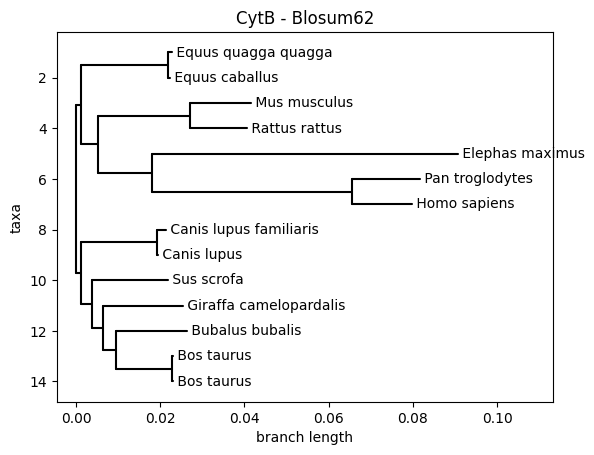

(((7:0.0010676272213459015,12:0.0006810612976551056):0.02058592438697815,((6:0.0145104443654418,8:0.013612180016934872):0.02176220901310444,(10:0.07264971733093262,(4:0.016248406472912275,5:0.014225345127599856):0.04750718176364899):0.012673994526267052):0.004116188734769821):0.0011806716211140156,((1:0.002086636843159795,2:0.00016280083218589425):0.01804947853088379,(3:0.018019655719399452,(11:0.018913911655545235,(0:0.016834044829010963,(9:0.0002277108287671581,13:0.00027054527890868485):0.013281716033816338):0.003196241334080696):0.00248489947989583):0.0027415454387664795):0.0011806716211140156);




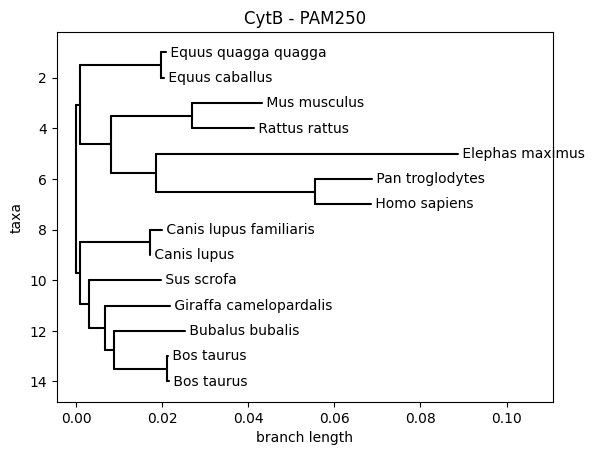

(((7:0.001200770610012114,12:0.000722306314855814):0.018859565258026123,((6:0.016345685347914696,8:0.014311248436570168):0.018729224801063538,(10:0.07004879415035248,(4:0.013318401242645642,5:0.013158676472480665):0.03690018877387047):0.010329607874155045):0.00734832976013422):0.0008744141086935997,((1:0.0026546993758529425,2:1.7149141058325768e-05):0.01638309843838215,(3:0.016597749665379524,(11:0.015158274210989475,(0:0.016543680801987648,(9:0.00022372769308276474,13:0.00026006525149568915):0.012459937483072281):0.0021010180935263634):0.0036506024189293385):0.002161359414458275):0.0008744141086935997);


In [16]:
b_tree, b_newick = generate_tree(blosum_dist_matrix)
p_tree, p_newick = generate_tree(pam_dist_matrix)

# Swapping out indexes for scientific names
mapping = {
    "0": "Bubalus bubalis",
    "1": "Canis lupus familiaris",
    "2": "Canis lupus",
    "3": "Sus scrofa",
    "4": "Pan troglodytes",
    "5": "Homo sapiens",
    "6": "Mus musculus",
    "7": "Equus quagga quagga",
    "8": "Rattus rattus",
    "9": "Bos taurus",
    "10": "Elephas maximus",
    "11": "Giraffa camelopardalis",
    "12": "Equus caballus",
    "13": "Bos taurus",
}

for clade in b_tree.find_clades():
  if clade.name in mapping:
    clade.name = mapping[clade.name]

for clade in p_tree.find_clades():
  if clade.name in mapping:
    clade.name = mapping[clade.name]

# Showing tree
Phylo.draw(b_tree, do_show=False)
plt.title("CytB - Blosum62")
plt.show()
print(b_newick)
print("\n")
Phylo.draw(p_tree, do_show=False)
plt.title("CytB - PAM250")
plt.show()
print(p_newick)

# Key

- [00] "BAA06892.1" - Bubalus bubalis (water buffalo)
- [01] "WYC28008.1" - Canis lupus familiaris (dog)
- [02] "WCB99710.1" - Canis lupus (gray wolf)
- [03] "CAA39742.1" - Sus scrofa (wild boar)
- [04] "NP_008198.1" - Pan troglodytes (chimpanzee)
- [05] "AAA19775.1" - Homo sapiens (human)
- [06] "P00158.1" - Mus musculus (house mouse)
- [07] "YP_009700119.1" - Equus quagga quagga (zebra)
- [08] "BAA85863.1" - Rattus rattus (black rat)
- [09] "CAA24007.1" - Bos taurus (cattle)
- [10] "YP_626379.1"- Elephas maximus (asiatic elephant)
- [11] "CCQ25751.1" - Giraffa camelopardalis (giraffe)
- [12] "ABB02178.1" - Equus caballus (horse)
- [13] "AAL57481.2" - Bos indicus (zebu/cattle)